In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# dataset.py

import torch
import os
import cv2
import numpy as np
from torch.utils.data import Dataset

class VehicleDataset(Dataset):
    def __init__(self, image_dir, label_dir, transforms=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transforms = transforms

        self.image_filenames = []
        all_image_files = sorted(os.listdir(self.image_dir))
        
        # Pre-filter the list to ensure every image has a corresponding, non-empty label file
        for img_file in all_image_files:
            # Check if the file is an image (optional but good practice)
            if not img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue
                
            label_file = os.path.splitext(img_file)[0] + ".txt"
            label_path = os.path.join(self.label_dir, label_file)
            
            if os.path.exists(label_path) and os.path.getsize(label_path) > 0:
                self.image_filenames.append(img_file)
        
        if not self.image_filenames:
            raise ValueError(f"No valid image/label pairs found in {image_dir} and {label_dir}")

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.image_dir, img_name)
        
        image = cv2.imread(img_path)
        img_height, img_width, _ = image.shape
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        label_name = os.path.splitext(img_name)[0] + ".txt"
        label_path = os.path.join(self.label_dir, label_name)
        
        boxes = []
        labels = []
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5: # Safety check for malformed lines
                    continue
                class_id = int(float(parts[0]))
                x_center_norm, y_center_norm, width_norm, height_norm = map(float, parts[1:])
                
                # De-normalize coordinates
                x_center = x_center_norm * img_width
                y_center = y_center_norm * img_height
                box_width = width_norm * img_width
                box_height = height_norm * img_height
                
                # Convert to [xmin, ymin, xmax, ymax]
                xmin = x_center - (box_width / 2)
                ymin = y_center - (box_height / 2)
                xmax = x_center + (box_width / 2)
                ymax = y_center + (box_height / 2)
                
                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(class_id + 1)

        # Create the dictionary to be passed to augmentations
        sample_to_transform = {
            'image': image,
            'bboxes': boxes,
            'labels': labels
        }
        
        if self.transforms:
            transformed_sample = self.transforms(**sample_to_transform)
            image = transformed_sample['image']
            
            # Use .get() to safely access keys that might be removed by transforms
            transformed_boxes = transformed_sample.get('bboxes', [])
            transformed_labels = transformed_sample.get('labels', [])
        else:
            # If no transforms, use original data
            transformed_boxes = boxes
            transformed_labels = labels

        # Create the final target dictionary for the model
        target = {}
        # Ensure boxes are FloatTensors and labels are LongTensors
        target['boxes'] = torch.as_tensor(transformed_boxes, dtype=torch.float32)
        target['labels'] = torch.as_tensor(transformed_labels, dtype=torch.int64)
        
        # CRUCIAL: Handle the case where there are no boxes after augmentation
        if target['boxes'].shape[0] == 0:
            # The model expects a tensor of shape [0, 4] for empty boxes
            target['boxes'] = torch.zeros((0, 4), dtype=torch.float32)

        return image, target

In [3]:
# transforms.py

import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define the training transforms
def get_train_transform():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        # Note: ToTensorV2 will convert the image to a PyTorch tensor
        # and move the channel dimension to the first position (C, H, W)
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

# Define the validation transforms (no random augmentations)
def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

# In transforms.py
def get_train_transform():
    return A.Compose([
        # Geometric augmentations
        A.HorizontalFlip(p=0.5),
        # Randomly adjust scale, keeping aspect ratio. This is very effective.
        A.RandomScale(scale_limit=0.1, p=0.5), 
        # Randomly crop, ensuring a minimum part of the original image is visible.
        # You might need to adjust min_visibility for your box sizes.
        A.RandomCrop(width=512, height=512, p=0.1), 
        
        # Color augmentations
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
        A.RandomBrightnessContrast(p=0.5),

        # Always end with conversion to tensor
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels'], 'min_visibility': 0.3})

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_320_fpn, FasterRCNN_MobileNet_V3_Large_320_FPN_Weights

def create_model(num_classes):
    """
    Creates a Faster R-CNN model with a MobileNetV3-Large-320-FPN backbone.
    
    This model is lightweight and optimized for faster inference, particularly
    on smaller input image sizes (around 320x320).
    
    Args:
        num_classes (int): The number of classes for the model to predict,
                           including the background class.
                           
    Returns:
        A PyTorch model.
    """
    
    # 1. Load the pre-trained Faster R-CNN model with MobileNetV3 backbone.
    # The 'DEFAULT' enum points to the best available pre-trained weights on the COCO dataset.
    model = fasterrcnn_mobilenet_v3_large_320_fpn(weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.DEFAULT)
    
    # 2. Get the number of input features for the classifier head.
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # 3. Replace the pre-trained head with a new one tailored to our number of classes.
    # This is the crucial step for fine-tuning the model on a custom dataset.
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# --- IMPORTANT NOTES ---
# 1. Re-training is Required: You must train a new model using this function.
#    Weights from a ResNet or any other architecture are incompatible.
# 2. Input Size: This model's name ("_320_") indicates it performs best with
#    smaller input images. While it will work on larger images, its internal
#    resizing and architecture are optimized for speed at this scale.

# Example of how to use this function:


In [5]:
# main.py

import torch
from torch.utils.data import DataLoader
#from dataset import VehicleDataset
#from transforms import get_train_transform, get_valid_transform
#from model import create_model  # Import our new function

# --- Hyperparameters and Configuration ---
TRAIN_IMG_DIR = '/kaggle/input/traffic-dataset/traffic_wala_dataset/train/images'
TRAIN_LBL_DIR = '/kaggle/input/traffic-dataset/traffic_wala_dataset/train/labels'
VALID_IMG_DIR = '/kaggle/input/traffic-dataset/traffic_wala_dataset/valid/images'
VALID_LBL_DIR = '/kaggle/input/traffic-dataset/traffic_wala_dataset/valid/labels'

BATCH_SIZE = 4
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
NUM_CLASSES = 2 # 1 class (Vehicle) + 1 background

# --- Data Loading ---
def collate_fn(batch):
    return tuple(zip(*batch))

# Instantiate datasets
train_dataset = VehicleDataset(
    image_dir=TRAIN_IMG_DIR,
    label_dir=TRAIN_LBL_DIR,
    transforms=get_train_transform()
)
valid_dataset = VehicleDataset(
    image_dir=VALID_IMG_DIR,
    label_dir=VALID_LBL_DIR,
    transforms=get_valid_transform()
)

# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)

print(f"Device: {DEVICE}")
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}")

# --- Model Initialization ---
print("\n--- Initializing Model ---")
model = create_model(num_classes=NUM_CLASSES)
model = model.to(DEVICE)
print("Model initialized and moved to device.")

# Let's inspect the model structure (optional)
#print(model)

# --- Test the DataLoader and Model ---
if __name__ == '__main__':
    print("\n--- Testing DataLoader and Model with a single batch ---")
    if len(train_loader) > 0:
        images, targets = next(iter(train_loader))
        
        # Move data to the correct device
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        
        # Get model output (during training, the model returns losses)
        model.train() # Set the model to training mode
        loss_dict = model(images, targets)
        
        losses = sum(loss for loss in loss_dict.values())
        
        print(f"Successfully performed a forward pass.")
        print(f"Loss dictionary: {loss_dict}")
        print(f"Total loss for the batch: {losses.item()}")
    else:
        print("Training loader is empty. Check your data paths.")

/usr/local/lib/python3.11/dist-packages/albumentations/core/composition.py:250: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


Device: cuda
Number of training samples: 536
Number of validation samples: 90

--- Initializing Model ---


Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth
100%|██████████| 74.2M/74.2M [00:00<00:00, 95.2MB/s]


Model initialized and moved to device.

--- Testing DataLoader and Model with a single batch ---
Successfully performed a forward pass.
Loss dictionary: {'loss_classifier': tensor(0.5715, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.4266, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.1245, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0875, device='cuda:0', grad_fn=<DivBackward0>)}
Total loss for the batch: 1.2100979089736938


In [6]:
# engine.py

import torch
from tqdm import tqdm # A library for progress bars

def train_one_epoch(model, optimizer, data_loader, device):
    """
    Trains the model for one epoch.

    Args:
        model: The object detection model.
        optimizer: The optimizer.
        data_loader: The DataLoader for the training data.
        device: The device to train on ('cuda' or 'cpu').

    Returns:
        The average loss for the epoch.
    """
    model.train() # Set the model to training mode
    
    total_loss = 0
    progress_bar = tqdm(data_loader, desc="Training")

    for images, targets in progress_bar:
        # Move data to the correct device
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # The model returns a dictionary of losses when in training mode
        loss_dict = model(images, targets)
        
        # Sum all the losses
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        
        total_loss += loss_value

        # Zero the gradients, perform backpropagation, and update the weights
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        # Update the progress bar with the current loss
        progress_bar.set_postfix(loss=loss_value)
    
    avg_loss = total_loss / len(data_loader)
    return avg_loss

@torch.no_grad() # Disable gradient calculations for validation
def validate(model, data_loader, device, metric_calculator):
    """
    Validates the model on the validation set.

    Args:
        model: The object detection model.
        data_loader: The DataLoader for the validation data.
        device: The device to validate on.
        metric_calculator: The TorchMetrics object for calculating mAP.
    
    Returns:
        The calculated mAP score dictionary.
    """
    model.eval() # Set the model to evaluation mode
    metric_calculator.reset() # Reset metrics before new validation run
    
    progress_bar = tqdm(data_loader, desc="Validation")
    
    for images, targets in progress_bar:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Get model predictions
        outputs = model(images)

        # Update the metric calculator with the new predictions and targets
        metric_calculator.update(outputs, targets)
        
    # Compute the final metrics
    metrics = metric_calculator.compute()
    return metrics

In [7]:
# main.py

import torch
from torch.utils.data import DataLoader
import torch.optim as optim
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import os

#from dataset import VehicleDataset
#from transforms import get_train_transform, get_valid_transform
#from model import create_model
#from engine import train_one_epoch, validate # Import the new functions

# --- Hyperparameters and Configuration ---
TRAIN_IMG_DIR = '/kaggle/input/traffic-dataset/traffic_wala_dataset/train/images'
TRAIN_LBL_DIR = '/kaggle/input/traffic-dataset/traffic_wala_dataset/train/labels'
VALID_IMG_DIR = '/kaggle/input/traffic-dataset/traffic_wala_dataset/valid/images'
VALID_LBL_DIR = '/kaggle/input/traffic-dataset/traffic_wala_dataset/valid/labels'

OUTPUT_DIR = '/kaggle/working/'
os.makedirs(OUTPUT_DIR, exist_ok=True)

BATCH_SIZE = 4
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
NUM_CLASSES = 2 # 1 class (Vehicle) + 1 background
NUM_EPOCHS = 25 # Start with 10 and increase if needed

# --- Data Loading ---
def collate_fn(batch):
    return tuple(zip(*batch))

# Instantiate datasets
train_dataset = VehicleDataset(
    image_dir=TRAIN_IMG_DIR,
    label_dir=TRAIN_LBL_DIR,
    transforms=get_train_transform()
)
valid_dataset = VehicleDataset(
    image_dir=VALID_IMG_DIR,
    label_dir=VALID_LBL_DIR,
    transforms=get_valid_transform()
)

# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)

print(f"Device: {DEVICE}")
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}")

# --- Model, Optimizer, and Metrics Initialization ---
print("\n--- Initializing Model ---")
model = create_model(num_classes=NUM_CLASSES)
model = model.to(DEVICE)

# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
# optimizer = optim.AdamW(params, lr=0.001, weight_decay=0.0001)

# # Learning rate scheduler
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

optimizer = optim.AdamW(params, lr=0.0005, weight_decay=0.0001)
# Use CosineAnnealingLR for smoother learning rate decay
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)


# Metric Calculator
# We set `iou_type="bbox"` because we are evaluating bounding boxes.
# The class_metrics=True will give us per-class AP, recall, and precision.
map_metric = MeanAveragePrecision(iou_type="bbox", class_metrics=True).to(DEVICE)


# --- The Main Training and Validation Loop ---
# In main.py

# ... (all the code above the loop remains the same) ...

# --- The Main Training and Validation Loop ---
# In main.py

# ... (all the code above the loop remains the same) ...

# --- The Main Training and Validation Loop ---
if __name__ == '__main__':
    best_map = 0.0 # To track the best performing model

    for epoch in range(NUM_EPOCHS):
        print(f"\n----- Epoch {epoch+1}/{NUM_EPOCHS} -----")
        
        # Train for one epoch
        train_loss = train_one_epoch(model, optimizer, train_loader, DEVICE)
        print(f"Epoch {epoch+1} Training Loss: {train_loss:.4f}")
        
        # Update the learning rate
        lr_scheduler.step()
        
        # Validate the model
        metrics = validate(model, valid_loader, DEVICE, map_metric)
        
        # --- CORRECTED METRIC ACCESS AND PRINTING ---
        print("\n--- Validation Metrics ---")
        
        map_val = metrics['map'].item()
        map_50_val = metrics['map_50'].item()
        mar_100_val = metrics['mar_100'].item()
        
        print(f"mAP @ .50:.95: {map_val:.4f}")
        print(f"mAP @ .50:     {map_50_val:.4f}")
        print(f"mAR @ .50:.95: {mar_100_val:.4f}")
        
        # --- ROBUST PER-CLASS METRIC HANDLING ---
        if 'map_per_class' in metrics and 'classes' in metrics:
            print("\n--- Per-Class AP @ .50:.95 ---")
            
            map_per_class = metrics['map_per_class']
            classes = metrics['classes']

            # Check if the tensors are 0-dimensional (scalar)
            if map_per_class.ndim == 0:
                # This handles the single-class case
                class_idx = classes.item()
                ap_val = map_per_class.item()
                print(f"  - Class {class_idx}: {ap_val:.4f}")
            else:
                # This handles the multi-class case
                for class_idx, ap_val in zip(classes, map_per_class):
                    print(f"  - Class {class_idx.item()}: {ap_val.item():.4f}")
        
        # Save the model if it has the best mAP so far
        if map_val > best_map:
            print(f"\nNew best model found! mAP improved from {best_map:.4f} to {map_val:.4f}")
            best_map = map_val
            torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, 'best_model.pth'))
            print("Best model saved to outputs/best_model.pth")

    print("\n--- Training Complete ---")
    print(f"Final best validation mAP: {best_map:.4f}")

/usr/local/lib/python3.11/dist-packages/albumentations/core/composition.py:250: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


Device: cuda
Number of training samples: 536
Number of validation samples: 90

--- Initializing Model ---

----- Epoch 1/25 -----


Training: 100%|██████████| 134/134 [00:16<00:00,  7.88it/s, loss=0.773]


Epoch 1 Training Loss: 0.8978


Validation: 100%|██████████| 23/23 [00:01<00:00, 15.49it/s]



--- Validation Metrics ---
mAP @ .50:.95: 0.1517
mAP @ .50:     0.3827
mAR @ .50:.95: 0.2305

--- Per-Class AP @ .50:.95 ---
  - Class 1: 0.1517

New best model found! mAP improved from 0.0000 to 0.1517
Best model saved to outputs/best_model.pth

----- Epoch 2/25 -----


Training: 100%|██████████| 134/134 [00:15<00:00,  8.77it/s, loss=1.1]  


Epoch 2 Training Loss: 0.9988


Validation: 100%|██████████| 23/23 [00:01<00:00, 15.73it/s]



--- Validation Metrics ---
mAP @ .50:.95: 0.1322
mAP @ .50:     0.3436
mAR @ .50:.95: 0.2148

--- Per-Class AP @ .50:.95 ---
  - Class 1: 0.1322

----- Epoch 3/25 -----


Training: 100%|██████████| 134/134 [00:15<00:00,  8.53it/s, loss=0.993]


Epoch 3 Training Loss: 1.0243


Validation: 100%|██████████| 23/23 [00:01<00:00, 15.83it/s]



--- Validation Metrics ---
mAP @ .50:.95: 0.1622
mAP @ .50:     0.4058
mAR @ .50:.95: 0.2273

--- Per-Class AP @ .50:.95 ---
  - Class 1: 0.1622

New best model found! mAP improved from 0.1517 to 0.1622
Best model saved to outputs/best_model.pth

----- Epoch 4/25 -----


Training: 100%|██████████| 134/134 [00:15<00:00,  8.75it/s, loss=0.966]


Epoch 4 Training Loss: 1.0543


Validation: 100%|██████████| 23/23 [00:01<00:00, 15.88it/s]



--- Validation Metrics ---
mAP @ .50:.95: 0.1649
mAP @ .50:     0.4276
mAR @ .50:.95: 0.2414

--- Per-Class AP @ .50:.95 ---
  - Class 1: 0.1649

New best model found! mAP improved from 0.1622 to 0.1649
Best model saved to outputs/best_model.pth

----- Epoch 5/25 -----


Training: 100%|██████████| 134/134 [00:15<00:00,  8.72it/s, loss=1.3]  


Epoch 5 Training Loss: 1.0695


Validation: 100%|██████████| 23/23 [00:01<00:00, 15.95it/s]



--- Validation Metrics ---
mAP @ .50:.95: 0.1651
mAP @ .50:     0.4286
mAR @ .50:.95: 0.2237

--- Per-Class AP @ .50:.95 ---
  - Class 1: 0.1651

New best model found! mAP improved from 0.1649 to 0.1651
Best model saved to outputs/best_model.pth

----- Epoch 6/25 -----


Training: 100%|██████████| 134/134 [00:15<00:00,  8.51it/s, loss=1.21] 


Epoch 6 Training Loss: 1.0568


Validation: 100%|██████████| 23/23 [00:01<00:00, 16.16it/s]



--- Validation Metrics ---
mAP @ .50:.95: 0.2025
mAP @ .50:     0.4907
mAR @ .50:.95: 0.2807

--- Per-Class AP @ .50:.95 ---
  - Class 1: 0.2025

New best model found! mAP improved from 0.1651 to 0.2025
Best model saved to outputs/best_model.pth

----- Epoch 7/25 -----


Training: 100%|██████████| 134/134 [00:15<00:00,  8.82it/s, loss=1.05] 


Epoch 7 Training Loss: 1.0753


Validation: 100%|██████████| 23/23 [00:01<00:00, 16.46it/s]



--- Validation Metrics ---
mAP @ .50:.95: 0.1967
mAP @ .50:     0.4913
mAR @ .50:.95: 0.2694

--- Per-Class AP @ .50:.95 ---
  - Class 1: 0.1967

----- Epoch 8/25 -----


Training: 100%|██████████| 134/134 [00:15<00:00,  8.64it/s, loss=1.16] 


Epoch 8 Training Loss: 1.0744


Validation: 100%|██████████| 23/23 [00:01<00:00, 16.38it/s]



--- Validation Metrics ---
mAP @ .50:.95: 0.2040
mAP @ .50:     0.4757
mAR @ .50:.95: 0.2797

--- Per-Class AP @ .50:.95 ---
  - Class 1: 0.2040

New best model found! mAP improved from 0.2025 to 0.2040
Best model saved to outputs/best_model.pth

----- Epoch 9/25 -----


Training: 100%|██████████| 134/134 [00:15<00:00,  8.82it/s, loss=0.999]


Epoch 9 Training Loss: 1.0842


Validation: 100%|██████████| 23/23 [00:01<00:00, 15.72it/s]



--- Validation Metrics ---
mAP @ .50:.95: 0.2222
mAP @ .50:     0.5153
mAR @ .50:.95: 0.2874

--- Per-Class AP @ .50:.95 ---
  - Class 1: 0.2222

New best model found! mAP improved from 0.2040 to 0.2222
Best model saved to outputs/best_model.pth

----- Epoch 10/25 -----


Training: 100%|██████████| 134/134 [00:15<00:00,  8.55it/s, loss=0.912]


Epoch 10 Training Loss: 1.0941


Validation: 100%|██████████| 23/23 [00:01<00:00, 16.25it/s]



--- Validation Metrics ---
mAP @ .50:.95: 0.2401
mAP @ .50:     0.5313
mAR @ .50:.95: 0.3045

--- Per-Class AP @ .50:.95 ---
  - Class 1: 0.2401

New best model found! mAP improved from 0.2222 to 0.2401
Best model saved to outputs/best_model.pth

----- Epoch 11/25 -----


Training: 100%|██████████| 134/134 [00:15<00:00,  8.73it/s, loss=0.93] 


Epoch 11 Training Loss: 1.0688


Validation: 100%|██████████| 23/23 [00:01<00:00, 15.85it/s]



--- Validation Metrics ---
mAP @ .50:.95: 0.2354
mAP @ .50:     0.5404
mAR @ .50:.95: 0.3012

--- Per-Class AP @ .50:.95 ---
  - Class 1: 0.2354

----- Epoch 12/25 -----


Training: 100%|██████████| 134/134 [00:15<00:00,  8.82it/s, loss=1.03] 


Epoch 12 Training Loss: 1.0792


Validation: 100%|██████████| 23/23 [00:01<00:00, 16.30it/s]



--- Validation Metrics ---
mAP @ .50:.95: 0.2432
mAP @ .50:     0.5332
mAR @ .50:.95: 0.3101

--- Per-Class AP @ .50:.95 ---
  - Class 1: 0.2432

New best model found! mAP improved from 0.2401 to 0.2432
Best model saved to outputs/best_model.pth

----- Epoch 13/25 -----


Training: 100%|██████████| 134/134 [00:15<00:00,  8.59it/s, loss=1.11] 


Epoch 13 Training Loss: 1.0744


Validation: 100%|██████████| 23/23 [00:01<00:00, 16.10it/s]



--- Validation Metrics ---
mAP @ .50:.95: 0.2638
mAP @ .50:     0.5724
mAR @ .50:.95: 0.3371

--- Per-Class AP @ .50:.95 ---
  - Class 1: 0.2638

New best model found! mAP improved from 0.2432 to 0.2638
Best model saved to outputs/best_model.pth

----- Epoch 14/25 -----


Training: 100%|██████████| 134/134 [00:15<00:00,  8.91it/s, loss=0.852]


Epoch 14 Training Loss: 1.0629


Validation: 100%|██████████| 23/23 [00:01<00:00, 15.63it/s]



--- Validation Metrics ---
mAP @ .50:.95: 0.2261
mAP @ .50:     0.5524
mAR @ .50:.95: 0.2972

--- Per-Class AP @ .50:.95 ---
  - Class 1: 0.2261

----- Epoch 15/25 -----


Training: 100%|██████████| 134/134 [00:15<00:00,  8.63it/s, loss=1.25] 


Epoch 15 Training Loss: 1.0604


Validation: 100%|██████████| 23/23 [00:01<00:00, 16.36it/s]



--- Validation Metrics ---
mAP @ .50:.95: 0.2715
mAP @ .50:     0.5756
mAR @ .50:.95: 0.3400

--- Per-Class AP @ .50:.95 ---
  - Class 1: 0.2715

New best model found! mAP improved from 0.2638 to 0.2715
Best model saved to outputs/best_model.pth

----- Epoch 16/25 -----


Training: 100%|██████████| 134/134 [00:15<00:00,  8.79it/s, loss=0.871]


Epoch 16 Training Loss: 1.0354


Validation: 100%|██████████| 23/23 [00:01<00:00, 16.64it/s]



--- Validation Metrics ---
mAP @ .50:.95: 0.2924
mAP @ .50:     0.5887
mAR @ .50:.95: 0.3635

--- Per-Class AP @ .50:.95 ---
  - Class 1: 0.2924

New best model found! mAP improved from 0.2715 to 0.2924
Best model saved to outputs/best_model.pth

----- Epoch 17/25 -----


Training: 100%|██████████| 134/134 [00:15<00:00,  8.63it/s, loss=0.932]


Epoch 17 Training Loss: 1.0060


Validation: 100%|██████████| 23/23 [00:01<00:00, 16.71it/s]



--- Validation Metrics ---
mAP @ .50:.95: 0.2937
mAP @ .50:     0.6025
mAR @ .50:.95: 0.3533

--- Per-Class AP @ .50:.95 ---
  - Class 1: 0.2937

New best model found! mAP improved from 0.2924 to 0.2937
Best model saved to outputs/best_model.pth

----- Epoch 18/25 -----


Training: 100%|██████████| 134/134 [00:15<00:00,  8.80it/s, loss=1.24] 


Epoch 18 Training Loss: 0.9971


Validation: 100%|██████████| 23/23 [00:01<00:00, 16.43it/s]



--- Validation Metrics ---
mAP @ .50:.95: 0.3008
mAP @ .50:     0.5915
mAR @ .50:.95: 0.3632

--- Per-Class AP @ .50:.95 ---
  - Class 1: 0.3008

New best model found! mAP improved from 0.2937 to 0.3008
Best model saved to outputs/best_model.pth

----- Epoch 19/25 -----


Training: 100%|██████████| 134/134 [00:15<00:00,  8.54it/s, loss=1.14] 


Epoch 19 Training Loss: 0.9706


Validation: 100%|██████████| 23/23 [00:01<00:00, 16.11it/s]



--- Validation Metrics ---
mAP @ .50:.95: 0.2996
mAP @ .50:     0.5919
mAR @ .50:.95: 0.3597

--- Per-Class AP @ .50:.95 ---
  - Class 1: 0.2996

----- Epoch 20/25 -----


Training: 100%|██████████| 134/134 [00:15<00:00,  8.84it/s, loss=1.02] 


Epoch 20 Training Loss: 0.9442


Validation: 100%|██████████| 23/23 [00:01<00:00, 15.15it/s]



--- Validation Metrics ---
mAP @ .50:.95: 0.3044
mAP @ .50:     0.5953
mAR @ .50:.95: 0.3649

--- Per-Class AP @ .50:.95 ---
  - Class 1: 0.3044

New best model found! mAP improved from 0.3008 to 0.3044
Best model saved to outputs/best_model.pth

----- Epoch 21/25 -----


Training: 100%|██████████| 134/134 [00:15<00:00,  8.81it/s, loss=0.907]


Epoch 21 Training Loss: 0.9057


Validation: 100%|██████████| 23/23 [00:01<00:00, 16.23it/s]



--- Validation Metrics ---
mAP @ .50:.95: 0.3073
mAP @ .50:     0.6038
mAR @ .50:.95: 0.3637

--- Per-Class AP @ .50:.95 ---
  - Class 1: 0.3073

New best model found! mAP improved from 0.3044 to 0.3073
Best model saved to outputs/best_model.pth

----- Epoch 22/25 -----


Training: 100%|██████████| 134/134 [00:15<00:00,  8.67it/s, loss=0.857]


Epoch 22 Training Loss: 0.8963


Validation: 100%|██████████| 23/23 [00:01<00:00, 16.06it/s]



--- Validation Metrics ---
mAP @ .50:.95: 0.3087
mAP @ .50:     0.6011
mAR @ .50:.95: 0.3671

--- Per-Class AP @ .50:.95 ---
  - Class 1: 0.3087

New best model found! mAP improved from 0.3073 to 0.3087
Best model saved to outputs/best_model.pth

----- Epoch 23/25 -----


Training: 100%|██████████| 134/134 [00:15<00:00,  8.73it/s, loss=0.828]


Epoch 23 Training Loss: 0.8951


Validation: 100%|██████████| 23/23 [00:01<00:00, 16.37it/s]



--- Validation Metrics ---
mAP @ .50:.95: 0.3070
mAP @ .50:     0.5966
mAR @ .50:.95: 0.3653

--- Per-Class AP @ .50:.95 ---
  - Class 1: 0.3070

----- Epoch 24/25 -----


Training: 100%|██████████| 134/134 [00:15<00:00,  8.66it/s, loss=0.822]


Epoch 24 Training Loss: 0.8911


Validation: 100%|██████████| 23/23 [00:01<00:00, 16.32it/s]



--- Validation Metrics ---
mAP @ .50:.95: 0.3109
mAP @ .50:     0.5946
mAR @ .50:.95: 0.3696

--- Per-Class AP @ .50:.95 ---
  - Class 1: 0.3109

New best model found! mAP improved from 0.3087 to 0.3109
Best model saved to outputs/best_model.pth

----- Epoch 25/25 -----


Training: 100%|██████████| 134/134 [00:15<00:00,  8.87it/s, loss=0.931]


Epoch 25 Training Loss: 0.8794


Validation: 100%|██████████| 23/23 [00:01<00:00, 16.33it/s]



--- Validation Metrics ---
mAP @ .50:.95: 0.3105
mAP @ .50:     0.5962
mAR @ .50:.95: 0.3689

--- Per-Class AP @ .50:.95 ---
  - Class 1: 0.3105

--- Training Complete ---
Final best validation mAP: 0.3109



--- Visualizing a batch of 4 images from the DataLoader ---


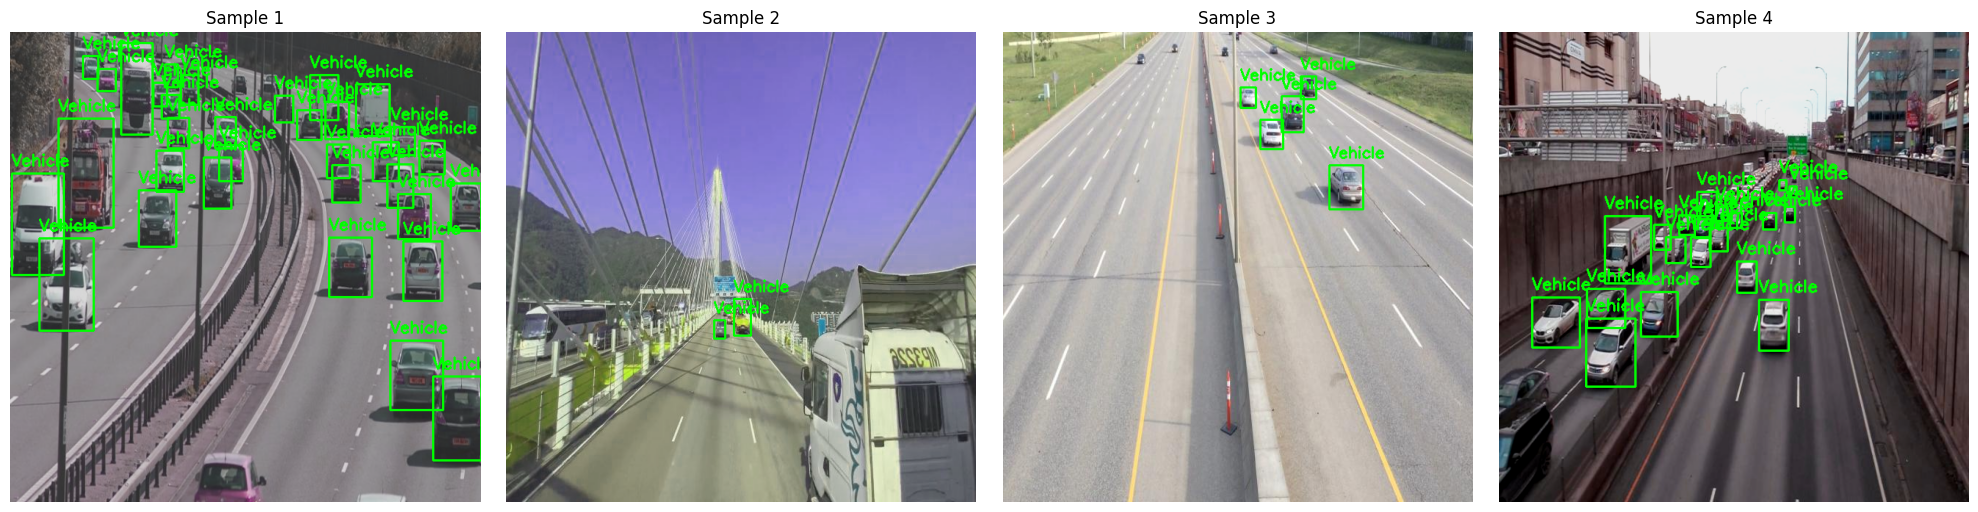

In [8]:
# utils.py

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define the classes (we have only one)
# Background is class 0, Vehicle is class 1
CLASSES = [
    '__background__', 'Vehicle'
]

# Define a color for our bounding boxes
# We can add more colors if we add more classes
COLORS = [
    (0, 0, 0), # Background
    (0, 255, 0) # Green for Vehicle
]

def visualize_batch(images, targets, num_samples=10):
    """
    Visualizes a batch of images with their corresponding bounding boxes.
    
    Args:
        images: A list of image tensors.
        targets: A list of target dictionaries.
        num_samples: The number of samples to display from the batch.
    """
    # Make sure we don't try to plot more images than we have
    num_samples = min(num_samples, len(images))
    
    # Create a figure to display the images
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))
    if num_samples == 1:
        axes = [axes] # Make it iterable if only one sample

    for i in range(num_samples):
        image_tensor = images[i]
        target = targets[i]

        # Convert tensor image to a NumPy array for OpenCV
        # Permute the dimensions from (C, H, W) to (H, W, C)
        image_np = image_tensor.permute(1, 2, 0).cpu().numpy()
        
        # Denormalize the image (from [0,1] to [0,255]) and convert to uint8
        image_np = (image_np * 255).astype(np.uint8)
        
        # Create a writable copy for drawing
        image_to_draw = image_np.copy()
        
        boxes = target['boxes'].cpu().numpy().astype(np.int32)
        labels = target['labels'].cpu().numpy()

        for box, label in zip(boxes, labels):
            xmin, ymin, xmax, ymax = box
            class_name = CLASSES[label]
            color = COLORS[label]
            
            # Draw the bounding box
            cv2.rectangle(image_to_draw, (xmin, ymin), (xmax, ymax), color, 2)
            
            # Put the class name text above the box
            cv2.putText(image_to_draw, class_name, (xmin, ymin-10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
            
        axes[i].imshow(image_to_draw)
        axes[i].set_title(f'Sample {i+1}')
        axes[i].axis('off')
        
    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    # --- VISUALIZATION TEST ---
    print("\n--- Visualizing a batch of 4 images from the DataLoader ---")
    if len(train_loader) > 0:
        images, targets = next(iter(train_loader))
        # Call the visualization function for up to 8 samples
        visualize_batch(images, targets, num_samples=8)
    else:
        print("Training loader is empty. Cannot visualize.")



In [9]:
# In utils.py

# ... (keep the other functions and imports) ...

def calculate_iou(box1, box2):
    """
    Calculates the Intersection over Union (IoU) of two bounding boxes.

    Args:
        box1 (list or tensor): [xmin, ymin, xmax, ymax]
        box2 (list or tensor): [xmin, ymin, xmax, ymax]

    Returns:
        float: The IoU value.
    """
    # Determine the coordinates of the intersection rectangle
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Compute the area of intersection
    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)

    # Compute the area of both bounding boxes
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Compute the area of the union
    union_area = box1_area + box2_area - intersection_area

    # Compute the IoU
    iou = intersection_area / union_area if union_area > 0 else 0
    return iou

Loading model...
Model loaded.


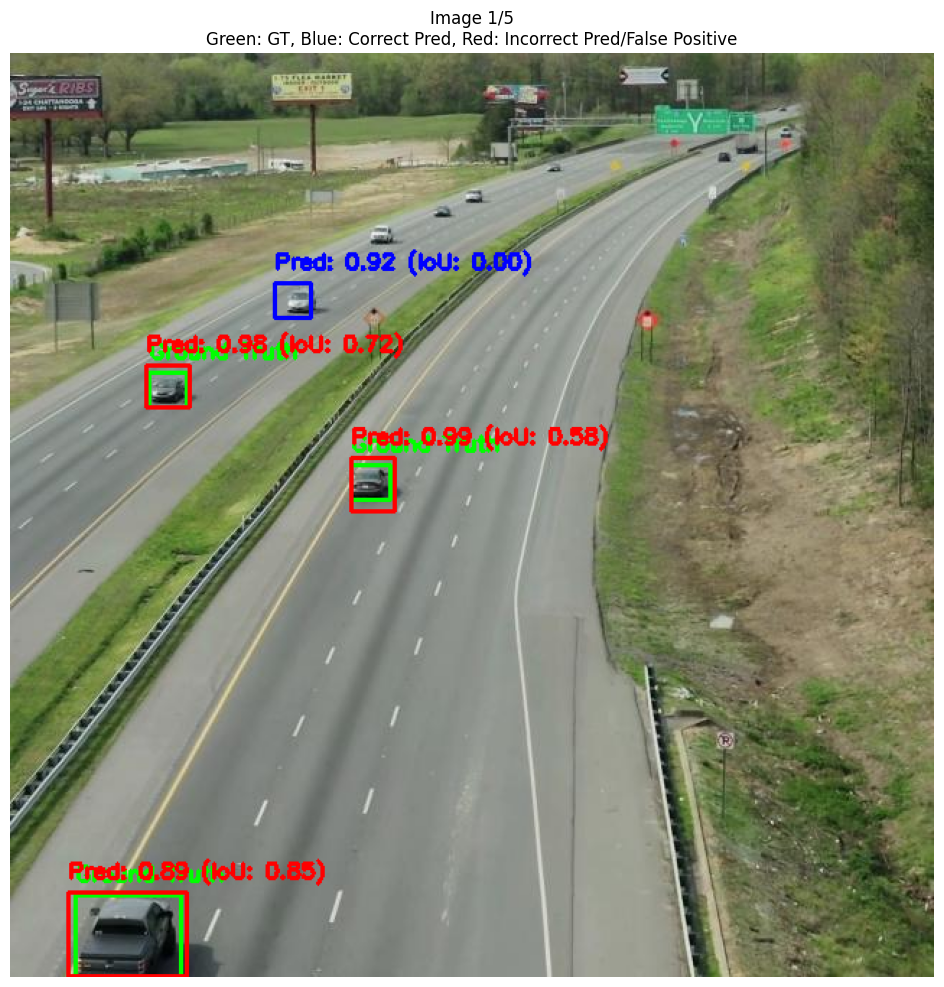

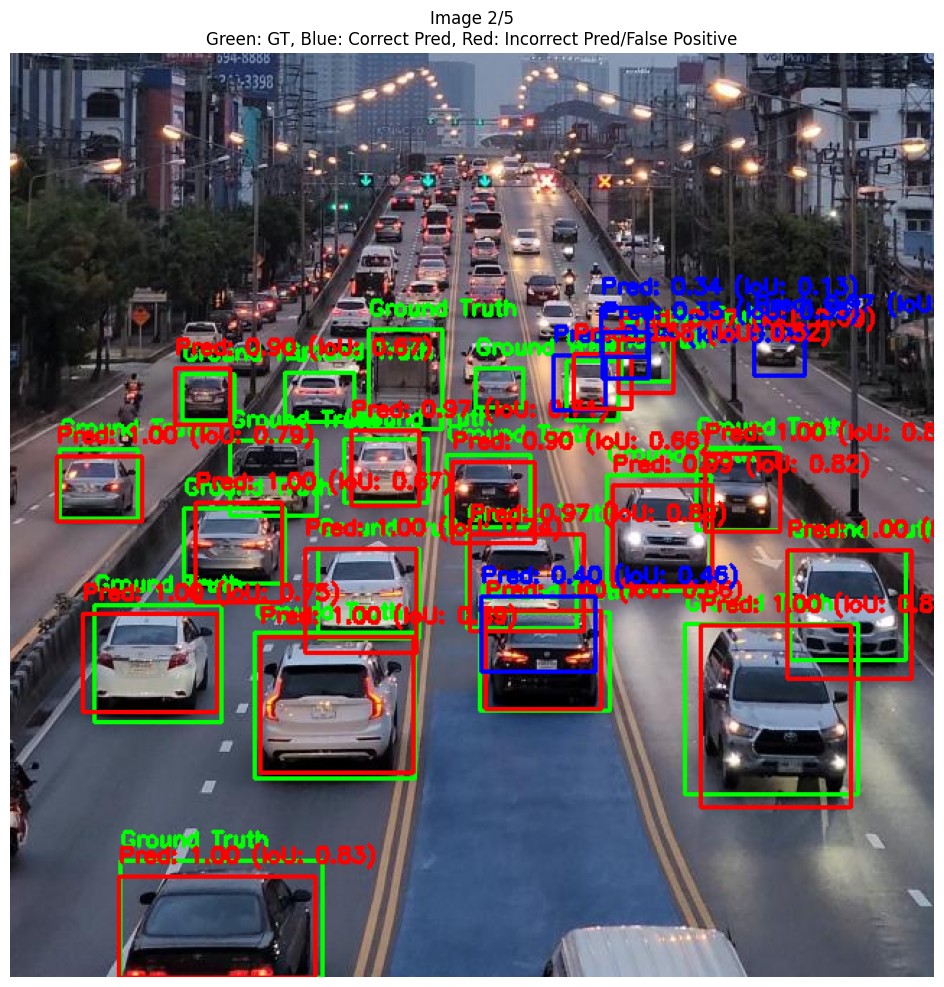

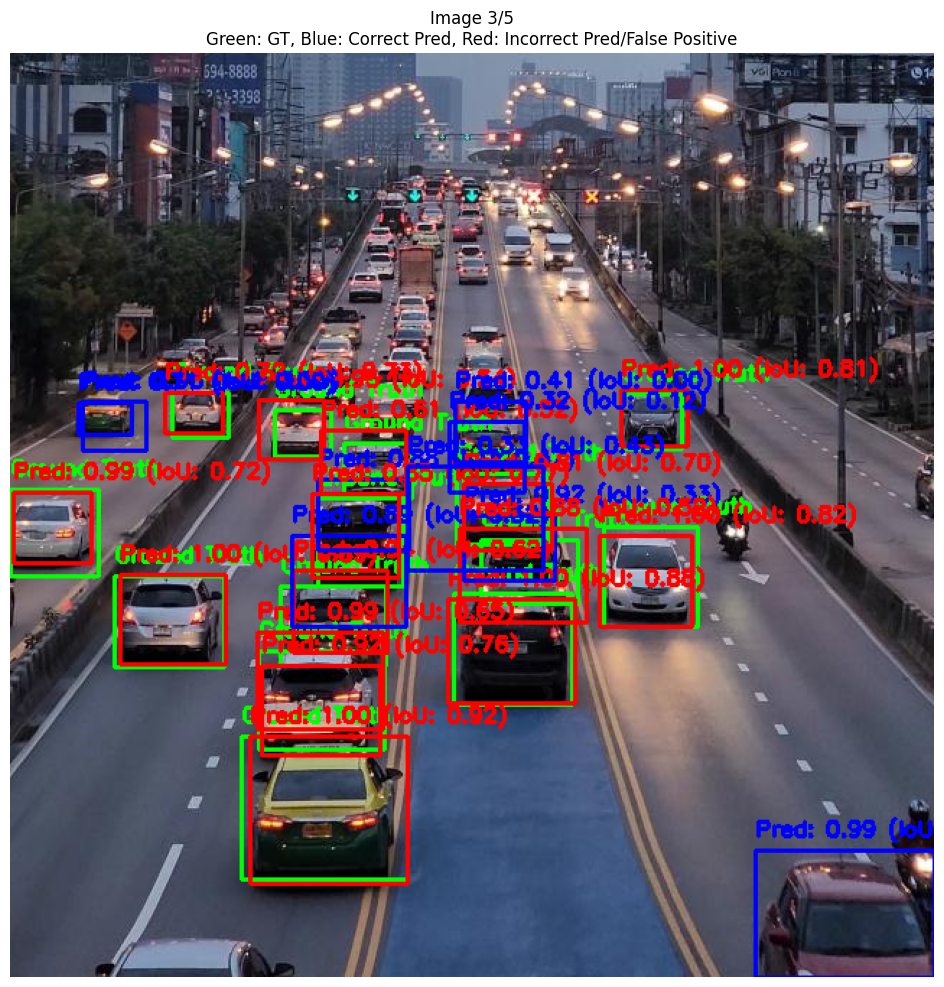

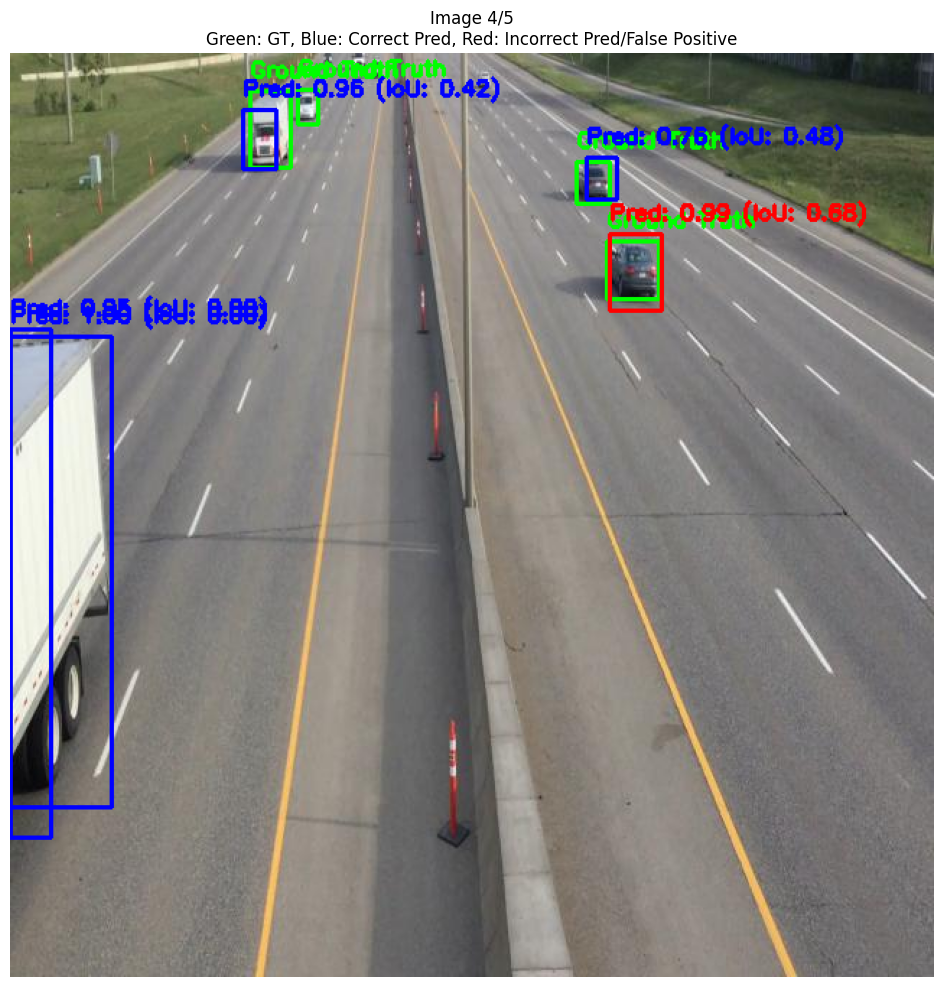

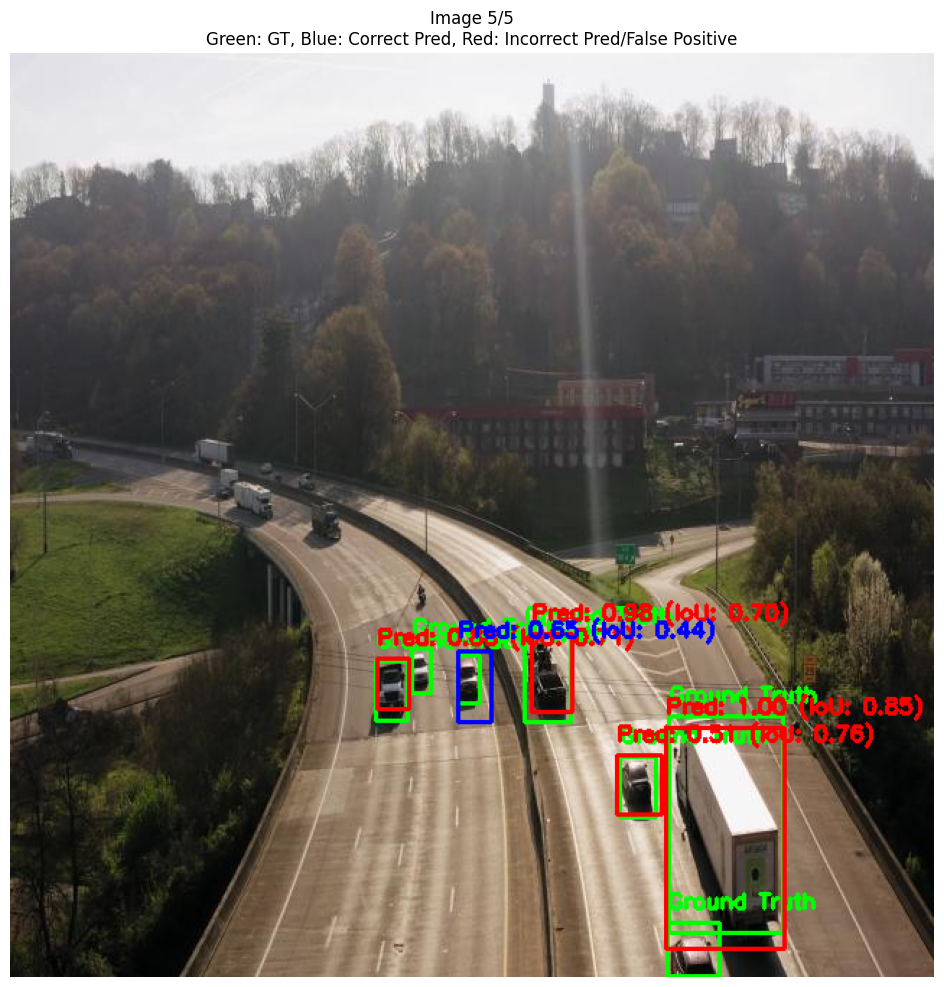

In [11]:
# visualize_results.py

import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import os # Added os import for path joining

# from dataset import VehicleDataset
# from transforms import get_valid_transform
# from model import create_model
# from utils import calculate_iou, collate_fn

# --- Configuration ---
DATA_IMG_DIR = '/kaggle/input/traffic-dataset/traffic_wala_dataset/valid/images'
DATA_LBL_DIR = '/kaggle/input/traffic-dataset/traffic_wala_dataset/valid/labels'
MODEL_PATH = '/kaggle/working/best_model.pth'

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
NUM_CLASSES = 2
CONFIDENCE_THRESHOLD = 0.3
IOU_THRESHOLD = 0.5

GT_COLOR = (0, 255, 0)       # Green
PRED_CORRECT_COLOR = (255, 0, 0) # Blue
PRED_INCORRECT_COLOR = (0, 0, 255) # Red

# --- Main Evaluation and Visualization Function ---
def analyze_predictions(num_images_to_show=5): # Add a parameter for flexibility
    # Load dataset and dataloader
    dataset = VehicleDataset(
        image_dir=DATA_IMG_DIR,
        label_dir=DATA_LBL_DIR,
        transforms=get_valid_transform()
    )
    data_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn) # Shuffle to see different images each time

    # Load model
    print("Loading model...")
    model = create_model(num_classes=NUM_CLASSES)
    
    # Ensure the model file exists
    if not os.path.exists(MODEL_PATH):
        print(f"Error: Model file not found at {MODEL_PATH}")
        return
        
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()
    print("Model loaded.")

    # --- MODIFICATION FOR 5 IMAGES ---
    images_shown = 0

    for images, targets in data_loader:
        if images_shown >= num_images_to_show:
            break

        image_tensor = images[0].to(DEVICE)
        target = targets[0]
        
        with torch.no_grad():
            output = model([image_tensor])[0]

        image_np = image_tensor.permute(1, 2, 0).cpu().numpy()
        image_to_draw = (image_np * 255).astype(np.uint8).copy()

        # Draw Ground Truth Boxes
        gt_boxes = target['boxes'].cpu().numpy().astype(int)
        for box in gt_boxes:
            cv2.rectangle(image_to_draw, (box[0], box[1]), (box[2], box[3]), GT_COLOR, 2)
            cv2.putText(image_to_draw, 'Ground Truth', (box[0], box[1] - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, GT_COLOR, 2)

        # Analyze and Draw Prediction Boxes
        pred_scores = output['scores'].cpu().numpy()
        pred_boxes = output['boxes'].cpu().numpy().astype(int)
        
        high_conf_indices = np.where(pred_scores >= CONFIDENCE_THRESHOLD)[0]
        
        for i in high_conf_indices:
            pred_box = pred_boxes[i]
            score = pred_scores[i]
            
            best_iou = 0
            if len(gt_boxes) > 0: # Only calculate IoU if there are ground truth boxes
                for gt_box in gt_boxes:
                    iou = calculate_iou(pred_box, gt_box)
                    if iou > best_iou:
                        best_iou = iou
            
            box_color = PRED_CORRECT_COLOR if best_iou >= IOU_THRESHOLD else PRED_INCORRECT_COLOR
            label_text = f"Pred: {score:.2f} (IoU: {best_iou:.2f})"
            
            cv2.rectangle(image_to_draw, (pred_box[0], pred_box[1]), (pred_box[2], pred_box[3]), box_color, 2)
            cv2.putText(image_to_draw, label_text, (pred_box[0], pred_box[1] - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, box_color, 2)
            
        # Display the image
        plt.figure(figsize=(12, 12))
        plt.imshow(image_to_draw)
        plt.title(f"Image {images_shown + 1}/{num_images_to_show}\nGreen: GT, Blue: Correct Pred, Red: Incorrect Pred/False Positive")
        plt.axis('off')
        plt.show()

        images_shown += 1 # Increment the counter

if __name__ == '__main__':
    analyze_predictions(num_images_to_show=5)